Add induction loops along analysis section

In [3]:
import os

file = "safety.add.xml"

with open(file, 'w') as f:
    f.write('<?xml version="1.0" encoding="UTF-8"?>\n')
    f.write('<additionals>\n')

    # f.write(f'<instantInductionLoop id="E0_0_1m" lane="e0_0" pos="1" file="inductionout.xml"/>\n')
    # f.write(f'<instantInductionLoop id="e0_1_1m" lane="e0_1" pos="1" file="inductionout.xml"/>\n')
    # f.write(f'<instantInductionLoop id="e0_2_1m" lane="e0_2" pos="1" file="inductionout.xml"/>\n')

    # for pos in range(50, 501, 50):
    #     for i in range(3):
    #         id = "e0_%d_%dm" % (i, pos)
    #         xml_line = f'<instantInductionLoop id="%s" lane="e0_%d" pos="%d" file="inductionout.xml"/>\n' % (id, i, pos)
    #         f.write(xml_line)

    for pos_ in range(50, 4451, 50):
        for i_ in range(2):
            id_ = "E1_%d_%dm" % (i_, pos_)
            xml_line = f'<instantInductionLoop id="%s" lane="E1_%d" pos="%d" file="inductionout.xml"/>\n' % (id_, i_, pos_)
            f.write(xml_line)

    f.write('</additionals>')

1data.py

In [20]:
import pandas as pd
import csv

# Code to prepare csv data for plotting of mean spot speeds
 
start_time = float(2446.70)
end_time = float(2446.70 + 600)

# Read the data from a CSV file
df = pd.read_csv('inductionout.csv', sep=';', dtype={5: str})

# Filter the data based on the time column
df = df[(df['instantOut_time'] >= start_time) & (df['instantOut_time'] <= end_time)]

# Extract the relevant portions of the string into new columns
df[['edge', 'lane', 'pos']] = df['instantOut_id'].str.extract(r'(E\d)_(\d)_(\d+)m', expand=True).fillna('')


# Check for rows where edge is e0 and pos is 500
# print(df[(df['edge'] == 'e0') & (df['pos'] == '500')])

# Filter the data based on the edge and pos columns
df = df[(df['edge'] == 'E1')]

# Group the data by the new columns and calculate the mean of another column
grouped = df.groupby(['edge', 'pos'])['instantOut_speed'].mean()

# Print the result
print(grouped)

# Save the result to a CSV file
grouped.to_csv('grouped_inductionout_base.csv', header=True)


edge  pos 
E1    100     22.638714
      1000    22.932090
      1050    23.124790
      1100    22.951946
      1150    22.951289
                ...    
      750     23.152802
      800     23.163862
      850     23.004614
      900     22.863643
      950     22.918132
Name: instantOut_speed, Length: 89, dtype: float64


2data_newcolumn.py

In [21]:
# Read the data from a CSV file
df = pd.read_csv('grouped_inductionout_base.csv')

# # Create a new column 'new_pos' and set its values based on the 'edge' column
# df['new_pos'] = df.apply(lambda row: row['pos'] if row['edge'] == 'e1' else row['pos'] - 500, axis=1)

# # Sort the data by the 'new_pos' column in ascending order
# df = df.sort_values(by='new_pos')

# m/s to kmph
df['Speed'] = df.apply(lambda row: row['instantOut_speed'] * 3.6, axis=1)

# Add a new column with the same value to the DataFrame
df['key'] = 'base'

# Print the updated DataFrame
print(df)

# Write the updated DataFrame to the same CSV file
df.to_csv('grouped_inductionout_base.csv', mode='w', header=True, index=False)


   edge   pos  instantOut_speed      Speed   key
0    E1   100         22.638714  81.499370  base
1    E1  1000         22.932090  82.555526  base
2    E1  1050         23.124790  83.249244  base
3    E1  1100         22.951946  82.627006  base
4    E1  1150         22.951289  82.624641  base
..  ...   ...               ...        ...   ...
84   E1   750         23.152802  83.350088  base
85   E1   800         23.163862  83.389904  base
86   E1   850         23.004614  82.816610  base
87   E1   900         22.863643  82.309113  base
88   E1   950         22.918132  82.505276  base

[89 rows x 5 columns]


3collate.py

In [22]:
# Paths to your csv files
csv_file_path1 = 'grouped_inductionout_base.csv'
csv_file_path2 = 'grouped_inductionout_brake.csv'

# Read the CSV files
df1 = pd.read_csv(csv_file_path1)
df2 = pd.read_csv(csv_file_path2)

# Combine the dataframes
combined_df = pd.concat([df1, df2], ignore_index=True)

# Save the combined dataframe to a new CSV file
combined_csv_path = 'combined_inductionout.csv'
combined_df.to_csv(combined_csv_path, index=False)


plot

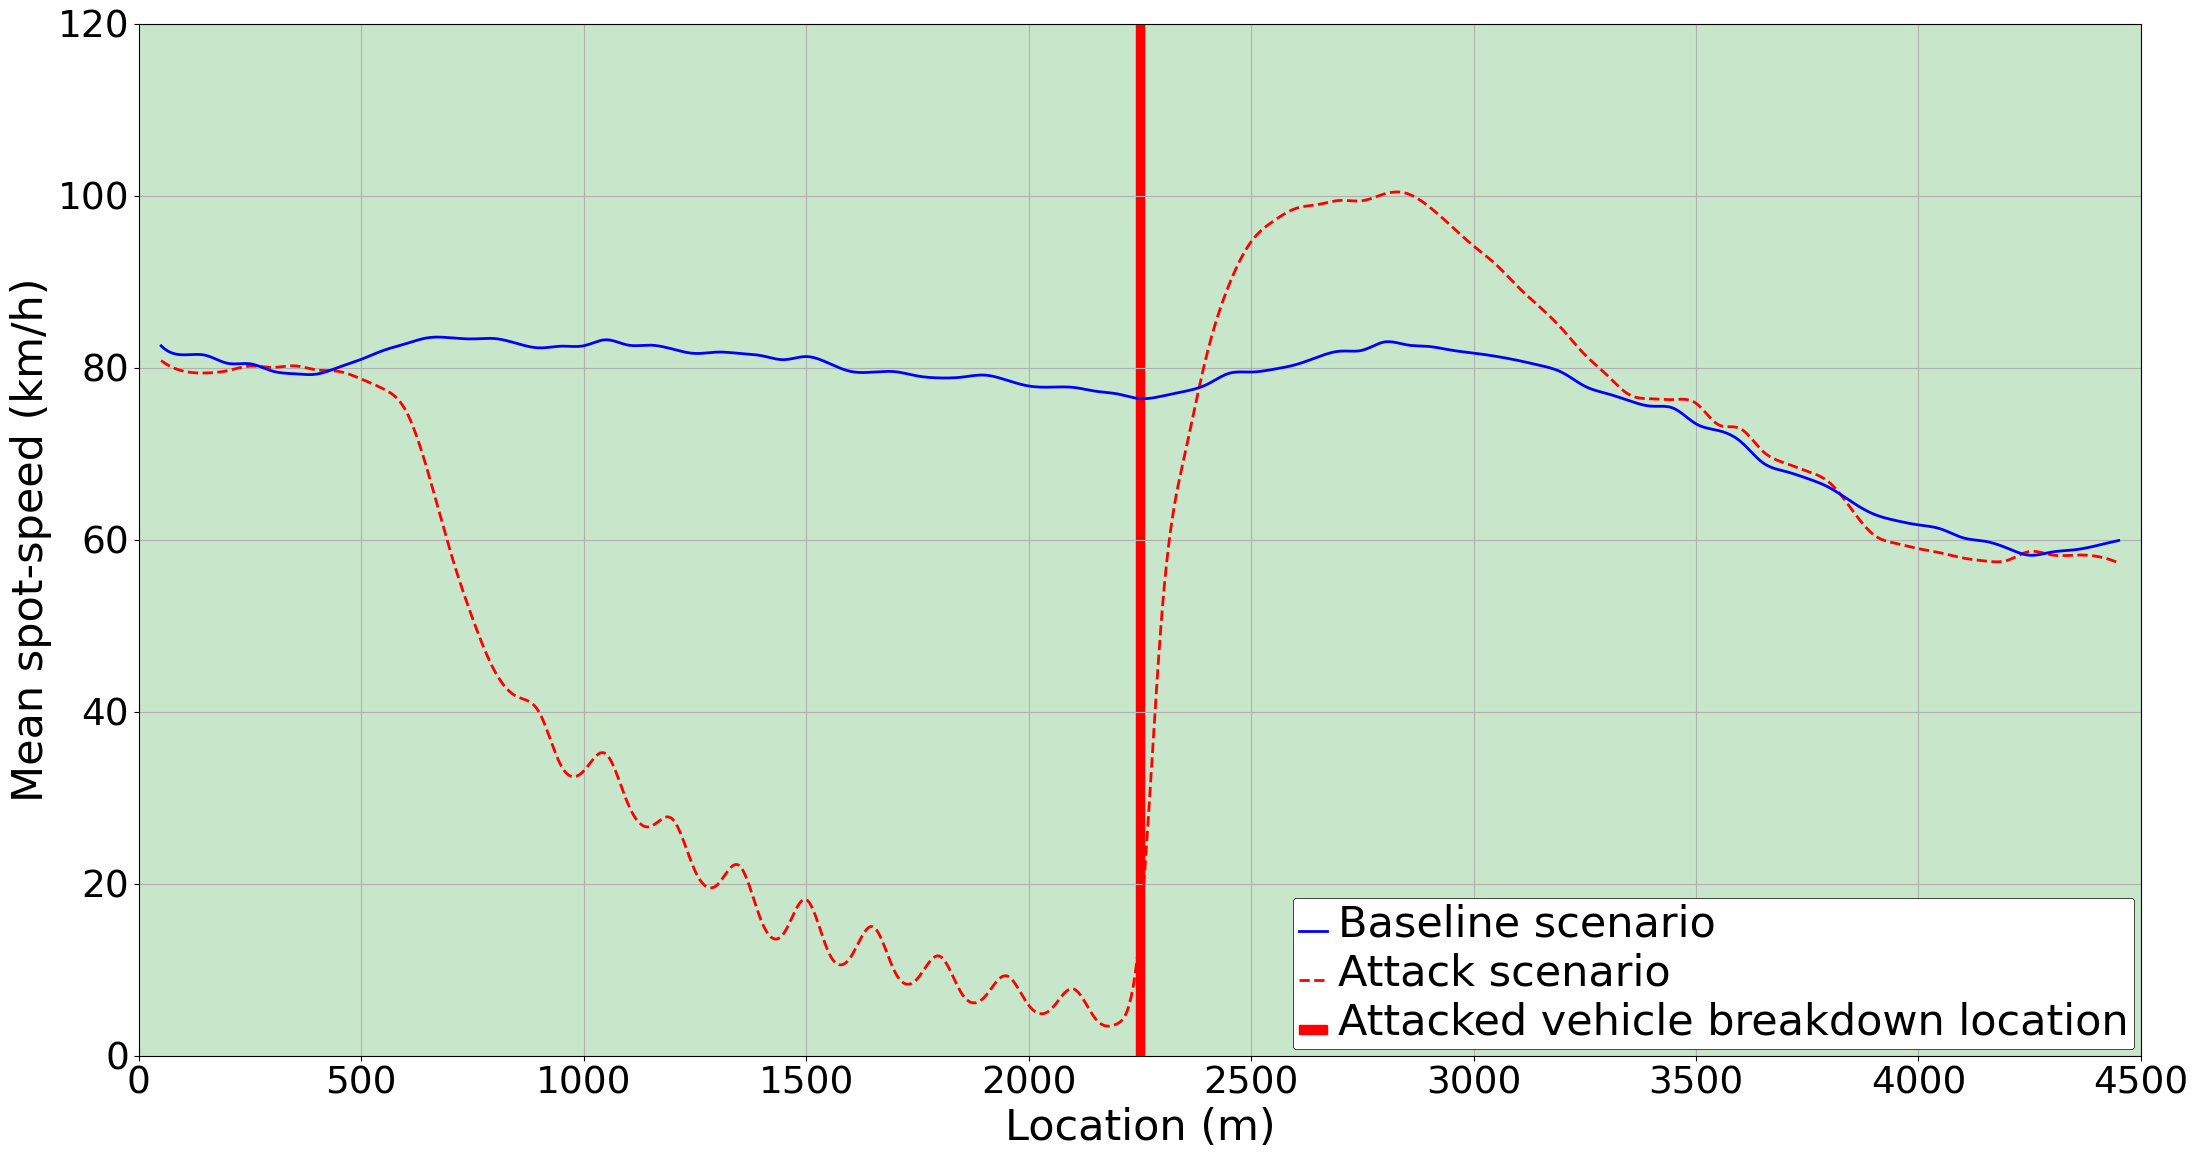

In [25]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Read the data from a CSV file
df = pd.read_csv('combined_inductionout.csv')

label_dict ={   'base': 'Baseline scenario', 
                'attack': 'Attack scenario'          
                }

# Define a dictionary to map key column values to colors
color_map = {'base': 'blue', 'attack': 'red'
             }

# Create a spline plot
fig, ax = plt.subplots(figsize=(22,12))
for key, group in df.groupby('key'):
    color = color_map[key]
    x = group['pos']
    y = group['Speed']
    f = interp1d(x, y, kind='cubic')
    xnew = np.linspace(x.min(), x.max(), num=1000, endpoint=True)
    linestyle = '--' if key in ['attack'] else '-'
    ax.plot(xnew, f(xnew), color=color, linestyle=linestyle, label=label_dict.get(key, key), linewidth=2)


# # Add a shaded strip of width 10m from x=505 to x=1000
# ax.axhspan(ymin=0, ymax=120, xmin=0.505, xmax=1, color='gray', alpha=0.5)

# Add a shaded strip of width 10m along x=500
ax.axhspan(ymin=0, ymax=120, xmin=0.498, xmax=0.502, color='red', alpha=1, label='Attacked vehicle breakdown location')

# # Add a shaded strip of width 10m from x=0 to x=495
# ax.axhspan(ymin=0, ymax=120, xmin=0, xmax=0.495, color='lightgray', alpha=0.5)

# Set the plot title and axis labels
# plt.title('Spot mean Speed vs. Location')
plt.xlabel('Location (m)', fontsize=31)
plt.ylabel('Mean spot-speed (km/h)', fontsize=31)

# Set the x and y limits of the plot
ax.set_xlim([0,4500])
ax.set_ylim([0,120])

# Set the background color to light green
ax.set_facecolor('#c8e6c9')

# turn the grid lines on
ax.grid(True, zorder=-2)

# legend
legend_order = ['Baseline scenario', 'Attack scenario',
                'Attacked vehicle breakdown location']
handles, labels = plt.gca().get_legend_handles_labels()
new_handles = [handles[labels.index(label)] for label in legend_order]
new_labels = legend_order

legend = plt.legend(new_handles, new_labels, loc='lower right')
legend.get_frame().set_facecolor('white')
legend.get_frame().set_linewidth(0.5)
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_alpha(1)
plt.setp(legend.get_texts(), fontsize=31)

# Set the font size of the x-axis tick labels
plt.xticks(fontsize=27)

# Set the font size of the y-axis tick labels
plt.yticks(fontsize=27)

# Set the subplot layout and adjust the whitespace
plt.subplots_adjust(left=0.06, bottom=0.09, right=0.97, top=0.95, wspace=0.2, hspace=0.2)

# Show the plot
plt.savefig('mean_flows_final_plus.png', format='png', dpi=300)
# plt.show()


Flowrate calculation
flow_induction.py

In [35]:
import pandas as pd
import sys

file = 'inductionout_brake.csv'

# Read the data from the CSV file
df = pd.read_csv(file, delimiter=';')

# Define the filter conditions
instantOut_state = 'enter'
time_windows = [(2446.70, 2446.70 + 600)]

# Group the data by instantOut_id and apply the filter conditions
groups = df[df['instantOut_state'] == instantOut_state].groupby('instantOut_id')

filtered_data = []

for name, group in groups:
    counts = {}
    for idx, window in enumerate(time_windows):
        start, end = window
        filtered_group = group[(group['instantOut_time'] >= group['instantOut_time'].iloc[0] + start) & (group['instantOut_time'] < group['instantOut_time'].iloc[0] + end)]
        count = len(filtered_group) * 6
        counts[f'count_q{idx + 1}'] = count
    counts['instantOut_id'] = name
    filtered_data.append(counts)

# Convert the filtered data to a DataFrame and print the results
filtered_df = pd.DataFrame(filtered_data)

# Save the filtered data to a CSV file
filtered_df.to_csv('filtered_inductionout.csv', index=False)

# Get the total at 2250m
print(filtered_df[filtered_df['instantOut_id'] == 'E1_0_2250m'])
print(filtered_df[filtered_df['instantOut_id'] == 'E1_1_2250m'])

/tmp/ipykernel_292108/1780799332.py:7: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file, delimiter=';')


    count_q1 instantOut_id
28       930    E1_0_2250m
     count_q1 instantOut_id
117       264    E1_1_2250m


getting speed during attack for both attack and base

In [41]:
import pandas as pd

# Define your file path and time range
csv_file_path = 'inductionout_brake.csv'
start_time = 2446.70  # start time value
end_time = 2446.70+600   # end time value

# Read the data from a CSV file
df = pd.read_csv(csv_file_path, sep=';')

# Filter rows for the specified IDs and the time range
filtered_df = df[(df['instantOut_id'].isin(['E1_0_2250m', 'E1_1_2250m'])) &
                 (df['instantOut_time'] >= start_time) &
                 (df['instantOut_time'] <= end_time)]

# Calculate the mean speed for the filtered rows
mean_speeds = filtered_df['instantOut_speed'].mean() * 3.6  # m/s to km/h

# Print the results
print(mean_speeds)


/tmp/ipykernel_292108/357468368.py:9: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file_path, sep=';')


14.34752686145146


moving average

/tmp/ipykernel_292108/3381119274.py:6: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('inductionout_brake.csv', sep=';')


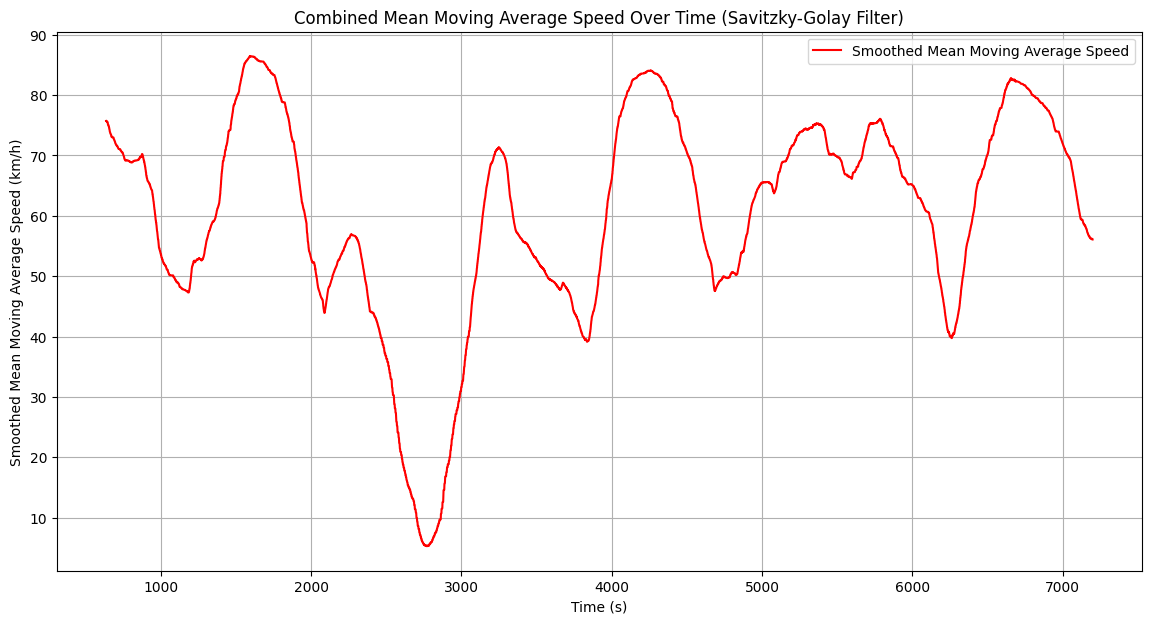

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# Load the data
df = pd.read_csv('inductionout_brake.csv', sep=';')

# Filter out the relevant IDs
filtered_df = df[df['instantOut_id'].isin(['E1_0_2250m', 'E1_1_2250m'])]

# Sort the data by time to ensure correct calculations
filtered_df = filtered_df.sort_values('instantOut_time')

# Calculate the moving average of the speed (convert m/s to km/h)
window_size = 3  # For moving average
filtered_df['moving_avg_speed'] = filtered_df['instantOut_speed'].rolling(window=window_size).mean() * 3.6

# Group by time and calculate mean speed across both IDs
mean_speed_over_time = filtered_df.groupby('instantOut_time')['moving_avg_speed'].mean()

# Apply the Savitzky-Golay filter
# window_length should be odd and less than the size of your data
# polyorder is the order of the polynomial used to fit the samples
window_length = 3001  # Choose an odd number, e.g., 5, 7, 9...
polyorder = 3
filtered_mean_speed = savgol_filter(mean_speed_over_time, window_length, polyorder)

# Plotting the combined mean moving average speed over time, smoothed by Savitzky-Golay filter
plt.figure(figsize=(14, 7))
plt.plot(mean_speed_over_time.index, filtered_mean_speed, label='Smoothed Mean Moving Average Speed', color='red')

plt.xlabel('Time (s)')
plt.ylabel('Smoothed Mean Moving Average Speed (km/h)')
plt.title('Combined Mean Moving Average Speed Over Time (Savitzky-Golay Filter)')
plt.legend(loc='best')
plt.grid(True)
plt.show()


/tmp/ipykernel_292108/1051457341.py:6: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('inductionout.csv', sep=';')


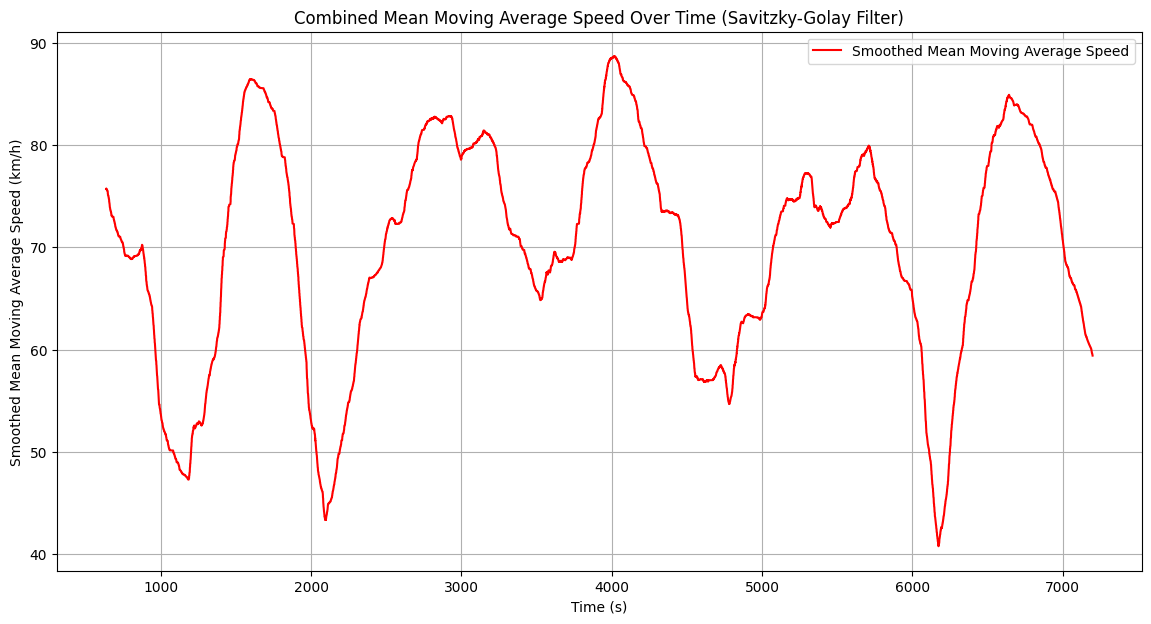

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# Load the data
df = pd.read_csv('inductionout.csv', sep=';')

# Filter out the relevant IDs
filtered_df = df[df['instantOut_id'].isin(['E1_0_2250m', 'E1_1_2250m'])]

# Sort the data by time to ensure correct calculations
filtered_df = filtered_df.sort_values('instantOut_time')

# Calculate the moving average of the speed (convert m/s to km/h)
window_size = 3  # For moving average
filtered_df['moving_avg_speed'] = filtered_df['instantOut_speed'].rolling(window=window_size).mean() * 3.6

# Group by time and calculate mean speed across both IDs
mean_speed_over_time = filtered_df.groupby('instantOut_time')['moving_avg_speed'].mean()

# Apply the Savitzky-Golay filter
# window_length should be odd and less than the size of your data
# polyorder is the order of the polynomial used to fit the samples
window_length = 3001  # Choose an odd number, e.g., 5, 7, 9...
polyorder = 3
filtered_mean_speed = savgol_filter(mean_speed_over_time, window_length, polyorder)

# Plotting the combined mean moving average speed over time, smoothed by Savitzky-Golay filter
plt.figure(figsize=(14, 7))
plt.plot(mean_speed_over_time.index, filtered_mean_speed, label='Smoothed Mean Moving Average Speed', color='red')

plt.xlabel('Time (s)')
plt.ylabel('Smoothed Mean Moving Average Speed (km/h)')
plt.title('Combined Mean Moving Average Speed Over Time (Savitzky-Golay Filter)')
plt.legend(loc='best')
plt.grid(True)
plt.show()


/tmp/ipykernel_292108/2069291974.py:7: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file, sep=';')
/tmp/ipykernel_292108/2069291974.py:7: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file, sep=';')


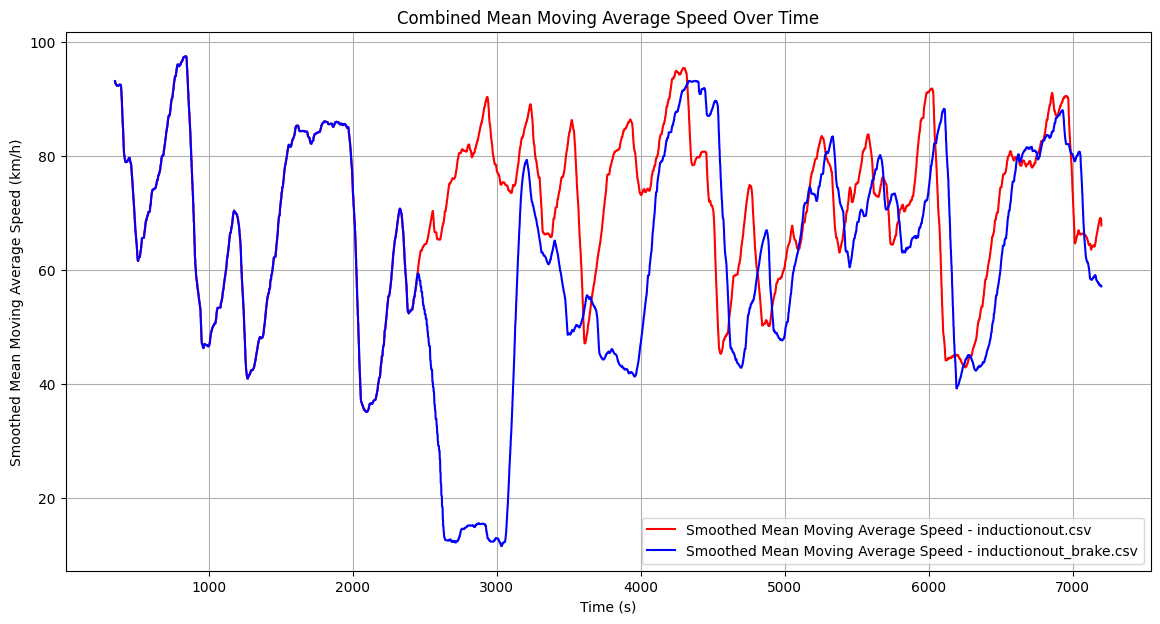

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

def process_data(csv_file):
    # Load the data
    df = pd.read_csv(csv_file, sep=';')

    # Filter out the relevant IDs
    filtered_df = df[df['instantOut_id'].isin(['E1_0_2250m', 'E1_1_2250m'])]

    # Sort the data by time to ensure correct calculations
    filtered_df = filtered_df.sort_values('instantOut_time')

    # Calculate the moving average of the speed (convert m/s to km/h)
    window_size = 600  # For moving average
    filtered_df['moving_avg_speed'] = filtered_df['instantOut_speed'].rolling(window=window_size).mean() * 3.6

    # Group by time and calculate mean speed across both IDs
    mean_speed_over_time = filtered_df.groupby('instantOut_time')['moving_avg_speed'].mean()

    return mean_speed_over_time

# Process each dataset
mean_speed_over_time_1 = process_data('inductionout.csv')
mean_speed_over_time_2 = process_data('inductionout_brake.csv')

# Apply the Savitzky-Golay filter to both
window_length = 51  # Ensure this is an appropriate, odd number that is less than the size of your data
polyorder = 3
filtered_mean_speed_1 = savgol_filter(mean_speed_over_time_1, window_length, polyorder)
filtered_mean_speed_2 = savgol_filter(mean_speed_over_time_2, window_length, polyorder)

# Plotting both datasets on the same graph
plt.figure(figsize=(14, 7))
plt.plot(mean_speed_over_time_1.index, filtered_mean_speed_1, label='Smoothed Mean Moving Average Speed - inductionout.csv', color='red')
plt.plot(mean_speed_over_time_2.index, filtered_mean_speed_2, label='Smoothed Mean Moving Average Speed - inductionout_brake.csv', color='blue')

plt.xlabel('Time (s)')
plt.ylabel('Smoothed Mean Moving Average Speed (km/h)')
plt.title('Combined Mean Moving Average Speed Over Time')
plt.legend(loc='best')
plt.grid(True)
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'combined_cve_data.csv'